In [1]:
from scipy.integrate import solve_ivp, odeint
import numpy as np
from scipy.special import kn, zeta
import matplotlib.pyplot as plt

In [2]:
@np.vectorize
def F(x,l=10.0):
    return l**2/x**2

@np.vectorize
def Finv(x,l=10.0):
    return 1/F(x,l)

def dFdx(x,l=10.0):
    return -2*l**2/x**3

def dFinvdx(x,l=10.0):
    return -dFdx(x,l)/F(x,l)**2

@np.vectorize
def Yeq(x):    
    s = 1/x**3
    g_star = 1
    g =1
    if x > 10: #non-relativistic regime
        Y_eq = (45/(4 * np.pi**4)) * (abs(g)/g_star)*x**(1.5)*np.sqrt(np.pi/2)*np.exp(-x)*(1 + (15/(8*(x))) + 105/(128 *(x)**2) - (315/(1024*x**3))) #(abs(g) * (m * T/ (2 * math.pi))**(3/2) * math.exp(-m/T))/s
    if x>(2/3): #semi-relativistic regime
        Y_eq = ((abs(g)/(2 * np.pi**2)) * ( (1/x)**2)* kn(2, x)/s) #(45 * abs(g) * (m/T)**2 * kn(2,(m/T)))/(4 * math.pi**4 * g_star)
    elif x <=(2/3): #relativistic regime
        Y_eq = ((3/4) * (zeta(3)/np.pi**2) * abs(g) * (1/x)**3)/s
    return Y_eq

def dYeqdx(x):    
    r = (Yeq(x+1e-4)-Yeq(x))*1e4
    return r

def dYdx(Y,x):
    return -F(x)*(Y**2-Yeq(x)**2)

def dGdx(G,x):
    a1 = -F(x)*G**2
    a2 = F(x)*(1+2*F(x))*Yeq(x)**2/((1+F(x))**2)
    a3 = -(2*G*F(x)**2/(1+F(x)) + dFdx(x)/((1+F(x))**2))
    a3 = a3*Yeq(x)
    a4 = -F(x)/(1+F(x))
    a4 = a4*dYeqdx(x)

    return a1+a2+a3+a4

def G0(x,Y0):
    return Y0 - Yeq(x)*(1 - 1/(1+F(x)))


In [7]:
hmax = 10.0
hmin = 0.05
hmax = 0
hmin = 0


x = np.linspace(0.5, 20, 1000)
Y0 = Yeq(x[0])
solA,dA = odeint(dYdx, Y0, x,hmin=hmin,hmax=hmax,full_output = True)

xB  = x[::100]
solB,dB = odeint(dYdx, Y0, xB,hmin=hmin,hmax=hmax,full_output = True)

In [17]:
solA_G,dA_G = odeint(dGdx,0.0, x,hmin=hmin,hmax=hmax,full_output = True)
solB_G,dB_G = odeint(dYdx,0.0, xB,hmin=hmin,hmax=hmax,full_output = True)

YAsol = Yeq(x)*(1- 1/(1+F(x))) + solA_G[:,0]
YBsol = Yeq(xB)*(1- 1/(1+F(xB))) + solB_G[:,0]

In [18]:
print(dA['nst'].max(),dA_G['nst'].max())
print(dA['nfe'].max(),dA_G['nfe'].max())
print(len(dA['nst']),len(dA_G['nst']))

190 332
389 689
999 999


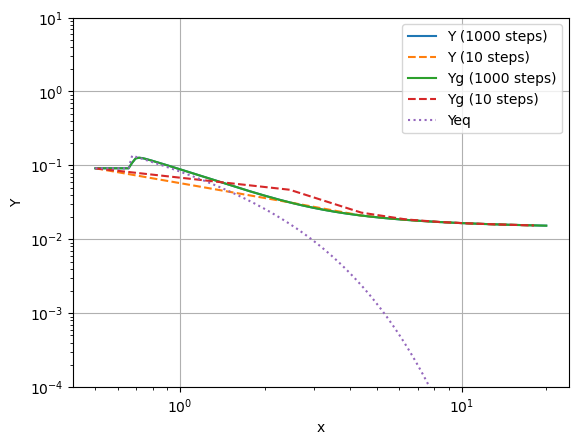

In [19]:
plt.plot(x, solA[:, 0], label=f'Y ({len(x)} steps)')
plt.plot(xB, solB[:, 0], label=f'Y ({len(xB)} steps)', linestyle='dashed')

plt.plot(x, YAsol, label=f'Yg ({len(x)} steps)')
plt.plot(xB, YBsol, label=f'Yg ({len(xB)} steps)', linestyle='dashed')


plt.plot(x, Yeq(x), label='Yeq', linestyle='dotted')
plt.xlabel('x')
plt.ylabel('Y')
plt.yscale('log')
plt.xscale('log')
# plt.xlim(x[0],20)
plt.ylim(1e-4,10)
plt.grid()
plt.legend()
plt.show()